In [10]:
import os,yaml
import pprint
import pandas as pd
import matplotlib.pyplot as plt
print("Package: yaml")
print(yaml.__version__)
print("Package: pandas")
print(pd.__version__)
#print("Package: matplotlib.pyplot")
#print(plt.__version__)


Package: yaml
6.0
Package: pandas
1.5.2


In [1]:
import os,yaml
import pprint

pp = pprint.PrettyPrinter(indent=4)

data_dir = r'../../trial_data'

def load_yaml(fn):
    cfg = None
    if fn is not None and os.path.isfile(fn):
        with open(fn, 'r') as f:
            cfg = yaml.full_load(f)
    return cfg

def load_init_data(trial_data_dir):
    init_fn = os.path.join(data_dir, 'assistance_init.yaml')
    init_data = load_yaml(init_fn)
    pp.pprint(init_data)
    return init_data
    
init_data_dict = load_init_data(data_dir)


{   'assistance_config': {   'enable_vis': True,
                             'goal_objects': ['kinova_holder'],
                             'log_dir': 'None',
                             'max_angular_velocity': 'None',
                             'max_linear_velocity': 'None',
                             'record_data': False,
                             'sim': True},
    'assistance_data': {   0: [0.4, 1.0, 0.0],
                           1: [0.4, 0.8, 0.6],
                           2: [0.4, 0.65, 0.75],
                           3: [0.4, 0.55, 0.9],
                           4: [0.4, 0.4, 1.0]},
    'goals': [   [   'kinova_holder',
                     [   [1.0, 0.0, 0.0, 0.542],
                         [0.0, 1.0, 0.0, 0.1077],
                         [0.0, 0.0, 1.0, 0.0053975],
                         [0.0, 0.0, 0.0, 1.0]]]],
    'input_control_paradigm_map': {   'buttons': {'next_mode': 'right_button'},
                                      'mode0': {   'x': 'left_rig

{   0: [0.4, 1.0, 0.0],
    1: [0.4, 0.8, 0.6],
    2: [0.4, 0.65, 0.75],
    3: [0.4, 0.55, 0.9],
    4: [0.4, 0.4, 1.0]}


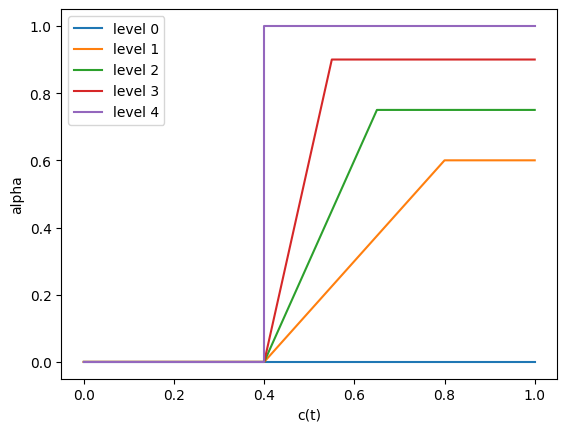

In [2]:
import matplotlib.pyplot as plt

def plot_assistance_levels(data_init_dict):
    assist_level_dict = data_init_dict['assistance_data']
    pp.pprint(assist_level_dict)
    fig, ax = plt.subplots()
    for key, thetas in assist_level_dict.items():
        ax.plot([0.0,thetas[0],thetas[1],1.0], [0.0,0.0,thetas[2],thetas[2]],label='level {}'.format(key))
        # If I want to annotate data points later: https://matplotlib.org/stable/tutorials/text/annotations.html#sphx-glr-tutorials-text-annotations-py
    ax.set_ylabel('alpha')
    ax.set_xlabel('c(t)')
    ax.legend()
    plt.show()
    

plot_assistance_levels(init_data_dict)

In [20]:
import pandas as pd
def get_trial_data(fn):
    df = pd.read_csv(fn)
    #print(df)
    return df

trial_df = get_trial_data(os.path.join(data_dir,"assistance_data.csv"))
print(trial_df)

joy_df = get_trial_data(os.path.join(data_dir,"joy.csv"))
print(joy_df)

joint_st_df = get_trial_data(os.path.join(data_dir,"joint_states.csv"))
print(joint_st_df)


         timestamp                               robot_state_ee_trans  \
0     1.660321e+09  [[1.8642127622425786e-06, 0.000201601351493441...   
1     1.660321e+09  [[1.8642127622425786e-06, 0.000201601351493441...   
2     1.660321e+09  [[1.8642127622425786e-06, 0.000201601351493441...   
3     1.660321e+09  [[1.8642127622425786e-06, 0.000201601351493441...   
4     1.660321e+09  [[1.8642127622425786e-06, 0.000201601351493441...   
...            ...                                                ...   
5904  1.660321e+09  [[-3.595267453249118e-06, 0.000231028860596615...   
5905  1.660321e+09  [[-3.595267453249118e-06, 0.000231028860596615...   
5906  1.660321e+09  [[-3.595267453249118e-06, 0.000231028860596615...   
5907  1.660321e+09  [[-3.5952674532768736e-06, 0.00023116201845491...   
5908  1.660321e+09  [[-3.5952674532768736e-06, 0.00023116201845491...   

     robot_state_finger_dofs  robot_state_mode  \
0                 [0.0, 0.0]                 0   
1                 [0.0,

In [73]:
# Need to get data to compute proximity between robot end effector and goal state along with level of assistance
# Making new dataframe from the relevant columns for proximity and level of assistance
prox_loa_df = trial_df[['timestamp','robot_state_ee_trans','robot_state_assist_state']].copy()
#print(trial_df.columns)
#print(prox_loa_df)
# Need to just grab level number from robot_state_assist_state column
assist_state_list = prox_loa_df.robot_state_assist_state.to_list()

# assist_state_list is a list of strings for whatever reason
# using regex to pull out the level number as an integer in this for loop
import re
prog = re.compile(r"{\'level\'\: (\d+)")
assist_level_list = []
for dict_el in assist_state_list:
    matches = prog.match(dict_el)
    level = int(matches.group(1))
    assist_level_list.append(level)
prox_loa_df = prox_loa_df.assign(assist_level=assist_level_list)
prox_loa_df = prox_loa_df.drop(columns='robot_state_assist_state')
#print(prox_loa_df)

# Same problem with robot_state_ee_trans: it's a string
import numpy as np
#print(prox_loa_df)
ee_state = prox_loa_df.robot_state_ee_trans.to_list()

# Found this sweet regex pattern from the following stack exchange answer: https://stackoverflow.com/a/4703508
numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
rx = re.compile(numeric_const_pattern, re.VERBOSE)
# This for loop converts each ee_transform from a string to a 4 by 4 numpy array of floats
np_ee_state = []
for ele in ee_state:
    num_list = rx.findall(ele)
    num_list = [float(num) for num in num_list]
    new_array = np.array([num_list[0:4],num_list[4:8],num_list[8:12],num_list[12:16]])
    np_ee_state.append(new_array)
#print(np_ee_state)

prox_loa_df = prox_loa_df.assign(ee_transform=np_ee_state)
prox_loa_df = prox_loa_df.drop(columns='robot_state_ee_trans')
print(prox_loa_df)



         timestamp  assist_level  \
0     1.660321e+09             0   
1     1.660321e+09             0   
2     1.660321e+09             0   
3     1.660321e+09             0   
4     1.660321e+09             0   
...            ...           ...   
5904  1.660321e+09             4   
5905  1.660321e+09             4   
5906  1.660321e+09             4   
5907  1.660321e+09             4   
5908  1.660321e+09             4   

                                           ee_transform  
0     [[1.8642127622425786e-06, 0.000201601351493441...  
1     [[1.8642127622425786e-06, 0.000201601351493441...  
2     [[1.8642127622425786e-06, 0.000201601351493441...  
3     [[1.8642127622425786e-06, 0.000201601351493441...  
4     [[1.8642127622425786e-06, 0.000201601351493441...  
...                                                 ...  
5904  [[-3.595267453249118e-06, 0.000231028860596615...  
5905  [[-3.595267453249118e-06, 0.000231028860596615...  
5906  [[-3.595267453249118e-06, 0.00023102886